In [1]:
import sys
import os
import pandas as pd


In [2]:
sys.path.append('..')

In [3]:
from icenode.train_icenode_2lr import ICENODE
from icenode.train_gram import GRAM
from icenode.train_retain import RETAIN

%load_ext autoreload
%autoreload 2

/home/asem/.conda/envs/icenode/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


In [4]:
HOME = os.environ.get('HOME')

# MIMIC-III Dataset Directory
mimic3_dir = f'{HOME}/GP/ehr-data/mimic3-transforms'

# ICE-NODE/M trained on MIMIC-III training partition (70%)
icenode_m3_params = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.2.20M3_icenode_2lr_M/trial_006/step0082_params.pickle'
icenode_m3_config = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.2.20M3_icenode_2lr_M/trial_006/config.json'

# RETAIN trained on MIMIC-III training partition (70%)
retain_m3_params = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.2.20M3_retain_M/trial_171/step0099_params.pickle'
retain_m3_config = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.2.20M3_retain_M/trial_171/config.json'

# GRU=GRAM/M trained on MIMIC-III training partition (70%)
gru_m3_params = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.2.20M3_gram_M/trial_649/step0096_params.pickle'
gru_m3_config = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.2.20M3_gram_M/trial_649/config.json'

# # GRAM=GRAM/G trained on MIMIC-III training partition (70%)
# gram_m3_dir = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.1.23M3_gram_G/frozen_trial_442'

## Patient Interface for each Model

In [5]:
icnode_patient_interface = ICENODE.create_patient_interface(mimic3_dir, 'M3')

In [6]:
retain_patient_interface = RETAIN.create_patient_interface(mimic3_dir, 'M3')
gram_patient_interface = GRAM.create_patient_interface(mimic3_dir, 'M3')

## Dataset Partitioning

In [7]:
import random

# seed 42 is used in all our experiments in this work.
rng = random.Random(42)
subjects_id = list(icnode_patient_interface.subjects.keys())
rng.shuffle(subjects_id)

# splits = train:val:test = 0.7:.15:.15
splits = int(.7 * len(subjects_id)), int(.85 * len(subjects_id))

train_ids = subjects_id[:splits[0]]
valid_ids = subjects_id[splits[0]:splits[1]]
test_ids = subjects_id[splits[1]:]

## Load Config/Params

In [8]:
from icenode.utils import load_config, load_params

icenode_config = load_config(icenode_m3_config)
icenode_params = load_params(icenode_m3_params)

retain_config = load_config(retain_m3_config)
retain_params = load_params(retain_m3_params)

gru_config = load_config(gru_m3_config)
gru_params = load_params(gru_m3_params)

# gram_config = load_config(f'{gram_m3_dir}/config.json')
# gram_params = load_params(f'{gram_m3_dir}/step0100_params.pickle')

## Load Models

In [9]:
icenode = ICENODE.create_model(icenode_config, icnode_patient_interface, train_ids, None)
icenode_state = icenode.init_with_params(icenode_config, icenode_params)

retain = RETAIN.create_model(retain_config, retain_patient_interface, train_ids, None)
retain_state = retain.init_with_params(retain_config, retain_params)


gru = GRAM.create_model(gru_config, gram_patient_interface, train_ids, None)
gru_state = gru.init_with_params(gru_config, gru_params)


## Per-code performance

In [10]:
from icenode.metrics import codes_auc_pairwise_tests

In [11]:
test_res = {
    'ICENODE': icenode.eval(icenode_state, test_ids)['diag_detectability'],
    'RETAIN': retain.eval(retain_state, test_ids)['diag_detectability'],
    'GRU': gru.eval(gru_state, test_ids)['diag_detectability']
}

In [12]:
tests = codes_auc_pairwise_tests(test_res)

100%|█████████████████████████████████████████| 242/242 [01:03<00:00,  3.84it/s]


In [13]:
tests

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN)
0,0,4.0,0.489303,0.614677,0.590547,0.258073,0.586623,0.894004
1,1,17.0,0.564101,0.643382,0.644628,0.179588,0.190191,0.981561
2,2,88.0,0.788767,0.785609,0.796071,0.786517,0.487360,0.473527
3,3,370.0,0.894996,0.901189,0.896929,0.259433,0.677353,0.504985
4,4,18.0,0.692679,0.610831,0.642337,0.218179,0.252416,0.612539
...,...,...,...,...,...,...,...,...
178,178,193.0,0.714232,0.731484,0.717521,0.204175,0.779997,0.296699
179,179,146.0,0.815041,0.814291,0.811493,0.950812,0.670746,0.842305
180,180,63.0,0.770714,0.771570,0.808014,0.959145,0.035524,0.027865
181,181,393.0,0.750262,0.791526,0.781738,0.000412,0.000026,0.280322


In [14]:
tests.isnull().sum()

CODE_INDEX                     0
N_POSITIVE_CODES               0
AUC(GRU)                       0
AUC(ICENODE)                   0
AUC(RETAIN)                    0
P0(AUC_GRU==AUC_ICENODE)       0
P0(AUC_GRU==AUC_RETAIN)        1
P0(AUC_ICENODE==AUC_RETAIN)    1
dtype: int64

In [15]:
# remove the code with null p-value
tests = tests[tests['P0(AUC_GRU==AUC_RETAIN)'].notnull() & tests['P0(AUC_ICENODE==AUC_RETAIN)'].notnull()]

In [16]:
from collections import defaultdict
auc_sets = defaultdict(set)
clfs = ('GRU', 'ICENODE', 'RETAIN')
clfs_pairs = []
for i in range(len(clfs)):
    for j in range(i + 1, len(clfs)):
        clfs_pairs.append((clfs[i], clfs[j]))
clfs_pairs = tuple(clfs_pairs)

In [17]:
# Extract codes that are predicted with equivalent performance with all classifiers.
test_cols = tuple(f'P0(AUC_{clf1}==AUC_{clf2})' for (clf1, clf2) in clfs_pairs)

In [18]:
common_perf = tests[(tests[test_cols[0]] > 0.05) & (tests[test_cols[1]] > 0.05) & (tests[test_cols[2]] > 0.05)]
auc_sets[clfs] = set(common_perf.CODE_INDEX)

In [19]:
common_perf

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN)
0,0,4.0,0.489303,0.614677,0.590547,0.258073,0.586623,0.894004
1,1,17.0,0.564101,0.643382,0.644628,0.179588,0.190191,0.981561
2,2,88.0,0.788767,0.785609,0.796071,0.786517,0.487360,0.473527
3,3,370.0,0.894996,0.901189,0.896929,0.259433,0.677353,0.504985
4,4,18.0,0.692679,0.610831,0.642337,0.218179,0.252416,0.612539
...,...,...,...,...,...,...,...,...
176,176,3.0,0.594765,0.783300,0.574221,0.089780,0.820214,0.101758
177,177,8.0,0.611763,0.551698,0.435814,0.250893,0.064814,0.167525
178,178,193.0,0.714232,0.731484,0.717521,0.204175,0.779997,0.296699
179,179,146.0,0.815041,0.814291,0.811493,0.950812,0.670746,0.842305


In [20]:
competing_tests = tests.drop(index=common_perf.index)

In [21]:
for index, row in competing_tests.iterrows():
    max_auc_clf = max(clfs, key=lambda clf: row[f'AUC({clf})'])
    relevant_tests = {(clf1, clf2): f'P0(AUC_{clf1}==AUC_{clf2})' for (clf1, clf2) in clfs_pairs if max_auc_clf in (clf1, clf2)}
    
    significant_max = True
    for (clf1, clf2), test_col in relevant_tests.items():
        # If max_auc_clf has maximum AUC, but without insigificant difference with another classifier
        # then consider both outperforming the third classifier.
        if row[test_col] > 0.05:
            significant_max = False
            auc_sets[(clf1, clf2)].add(int(row['CODE_INDEX']))
    
    if significant_max:
        auc_sets[max_auc_clf].add(int(row['CODE_INDEX']))

In [22]:
auc_sets

defaultdict(set,
            {('GRU', 'ICENODE', 'RETAIN'): {0,
              1,
              2,
              3,
              4,
              5,
              6,
              7,
              8,
              9,
              11,
              12,
              13,
              14,
              16,
              17,
              18,
              19,
              20,
              22,
              23,
              24,
              25,
              26,
              28,
              29,
              30,
              32,
              33,
              34,
              35,
              36,
              37,
              38,
              39,
              41,
              42,
              43,
              44,
              45,
              48,
              50,
              51,
              53,
              55,
              57,
              59,
              61,
              62,
              63,
              65,
              66,
              69,
         

In [23]:
# Prepare for using Upset plot

upset_contents = {}
for clf in clfs:
    upset_contents[clf] = auc_sets[clf] | auc_sets[clfs]
    
    for clf1, clf2 in clfs_pairs:
        if clf in (clf1, clf2):
            upset_contents[clf].update(auc_sets[(clf1, clf2)])
    

In [24]:
upset_contents

{'GRU': {0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  11,
  12,
  13,
  14,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  41,
  42,
  43,
  44,
  45,
  47,
  48,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  61,
  62,
  63,
  65,
  66,
  69,
  70,
  71,
  72,
  73,
  74,
  76,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  88,
  89,
  90,
  92,
  93,
  94,
  95,
  96,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  119,
  120,
  121,
  123,
  124,
  125,
  127,
  130,
  131,
  132,
  133,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  154,
  155,
  157,
  158,
  159,
  160,
  161,
  162,
  163,
  164,
  166,
  168,
  169,
  170,
  172,
  175,
  176,
  177,
  178,
  179,
  182},
 'ICENODE': {0,


In [25]:
from upsetplot import from_contents, plot, UpSet
import matplotlib.pyplot as plt

In [26]:
upset_contents = from_contents(upset_contents)

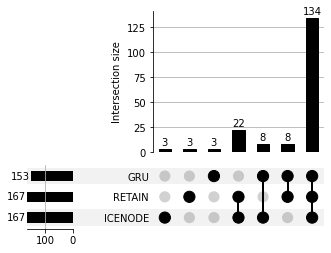

In [27]:
UpSet(upset_contents, subset_size='count', show_counts=True).plot()
plt.show()

In [28]:
auc_sets['ICENODE']

{10, 60, 126}

In [29]:
flatccs_idx2code = {idx: code for code, idx in icnode_patient_interface.diag_flatccs_idx.items()}

In [30]:
flatccs_icenode = list(map(flatccs_idx2code.get, auc_sets['ICENODE']))

In [31]:
flatccs_icenode

['107', '153', '212']

In [32]:
flatccs_icenode_desc = list(map(icnode_patient_interface.dag.diag_flatccs_desc.get, flatccs_icenode))

In [33]:
flatccs_icenode_desc

['Cardia arrst', 'GI hemorrhag', 'Ot bone dx']

In [34]:
competing_tests

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN)
10,10,353.0,0.839473,0.864679,0.850782,0.000355,0.068174,0.045409
15,15,2.0,0.464747,0.766137,0.626117,0.001028,0.399450,0.164539
21,21,98.0,0.725419,0.680145,0.681769,0.049405,0.019013,0.931838
27,27,2.0,0.977656,0.966733,0.957299,0.025967,0.000406,0.149483
31,31,63.0,0.689184,0.693429,0.738297,0.872586,0.008128,0.041081
40,40,197.0,0.749537,0.780007,0.777256,0.013306,0.003244,0.802132
46,46,18.0,0.708487,0.726315,0.864839,0.722481,0.039425,0.067560
47,47,20.0,0.655662,0.730789,0.645096,0.086181,0.821472,0.047147
49,49,3.0,0.711067,0.776011,0.724321,0.016606,0.389755,0.187346
52,52,10.0,0.909910,0.556757,0.806907,0.001243,0.000022,0.030788
